In [1]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
from PIL import ImageFilter
from PIL import Image

%matplotlib inline

In [81]:
#Unsharpened original image
text = pytesseract.image_to_string(img)
print(text)

HAPPY HOUR

wynxm OYSTER $1

n :5: Skin

Hmrwtss r‘ r ‘ a mum
\‘mlmhnw

 

'wupu mum 3

BUTTERBEM HUMWUS
‘Jsmhmmnuum'e mum 9mm \nH.‘|u'mh ;

mupnto sucksmwu mm
panmsan muvc mp s

V‘CTORIAN

«m rnmmuu‘ Lcmuu dnunrv'mlv:mnm 9

HOUSE W‘NF '

<7 ARvHHx WHH

2

half of] ALL 750ml BOTTLES OF
SPARKLING E=- ROSE WINE

700‘ CHESTNUTST SAN FRANChSCO c4


In [2]:
#Code for pytesseract text recognition
#This will be used downstream to pull text from an image
#Seems to be clearest with sharpened image. Tried grayscaling sharpened image, but that reduced performance
import pytesseract


#img = Image.open('../../python_stuff/test_41.jpg')

text = pytesseract.image_to_string(im1_sharp)
print(text)

#with open('magic.txt', mode='w') as file:
#    file.write(text)

NameError: name 'im1_sharp' is not defined

In [80]:
#Image to grayscale
#test image is in ../..
img = cv2.imread('../../python_stuff/test_41.jpg', cv2.IMREAD_GRAYSCALE)


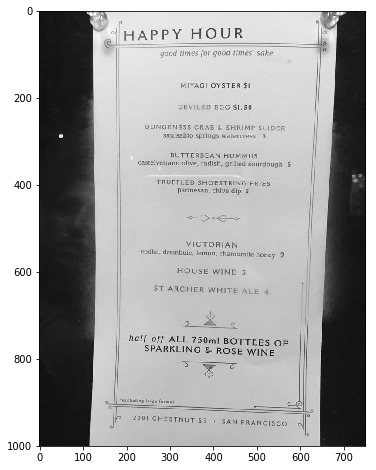

In [18]:
#plotting image to see what grayscale looks like
plt.figure(figsize=(12,8))
plt.imshow(img, cmap='gray')

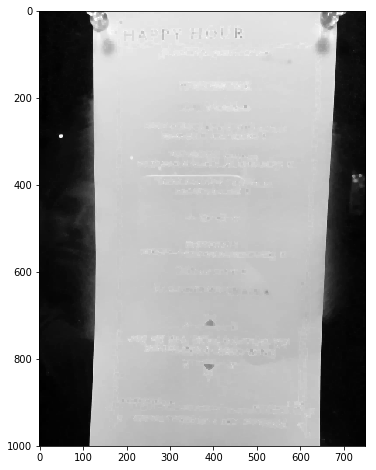

In [20]:
#closing dilates and then errodes an image to effectively close small gaps
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(12,8))
plt.imshow(closing, cmap='gray')

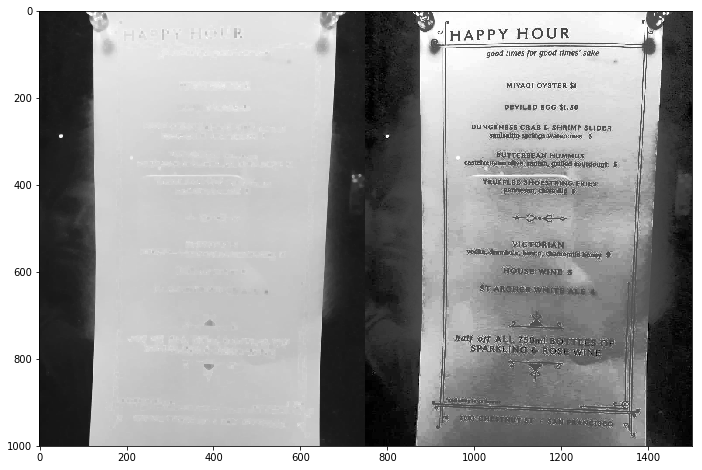

In [30]:
equ = cv2.equalizeHist(img)
res = np.hstack((closing,equ)) #stacking images side-by-side
plt.figure(figsize=(12,8))
plt.imshow(res, cmap='gray')

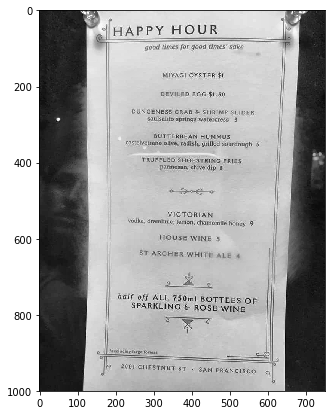

In [29]:
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)

plt.figure(figsize = (12,7))
plt.imshow(cl1, cmap='gray')

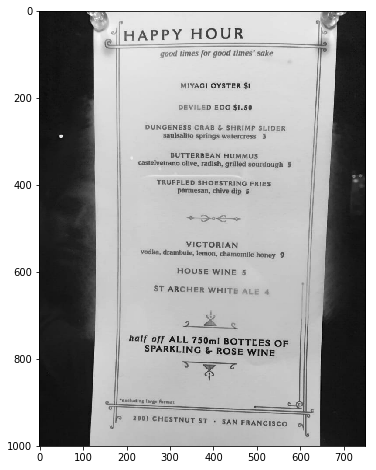

In [41]:
#Closing followed by equalization does not seem to improve readability of the file.
#Just dilation

kernel= np.ones((2,2),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)
plt.figure(figsize=(12,8))
plt.imshow(erosion, cmap='gray')

In [45]:
im1 = img.filter(ImageFilter.BLUR)

plt.figure(figsize=(12,8))
plt.imshow(erosion, cmap='gray')

AttributeError: 'numpy.ndarray' object has no attribute 'filter'

In [73]:
im1 = Image.open('../../python_stuff/test_41.jpg')

In [74]:
im1_sharp = im1.filter(ImageFilter.SHARPEN)

In [82]:
im1.close()
im1_sharp.close()

In [59]:
pix = np.array(im1_sharp)

In [60]:
pix.shape

(1000, 750, 3)

In [69]:
img_sharp = cv2.cvtColor(pix, cv2.COLOR_BGR2GRAY)

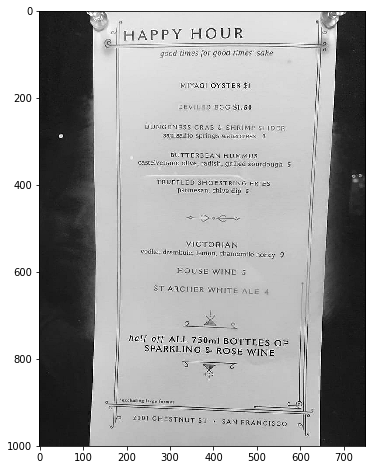

In [70]:
plt.figure(figsize=(12,8))
plt.imshow(img_sharp, cmap='gray')

## Setting up Picture Dataframe

In [2]:
#Creates list of file names in data directory
file_names = os.listdir('data')

In [3]:
#A hidden file ended up in my file_names. Need to remove all hidden files from file_names
'.DS_Store' in file_names

True

In [4]:
#Removes all hidden files from file_list
def remove_hidden(file_list):
    #try block to account for error when there are no hidden files in file_list
    try:
        #Sorting will place hidden files at top
        sorted_files = sorted(file_list)
        for i, file in enumerate(sorted_files):
            if file[0] == '.':
                max_period = i
        return sorted_files[max_period+1:]
    
    #returns original file_list if no hidden files
    except:
        return file_list

In [5]:
#convert file_names
file_names = remove_hidden(file_names)

In [6]:
#Loads image, converts to gray scale, resizes, and scales
def convert_image(file_path):
    with Image.open(file_path).convert('L') as image:
        resized = image.resize((300, 400))
        result = np.array(resized)
        result = result.reshape(result.shape[0], result.shape[1], 1)
        scaled = result / 255
    return scaled

In [7]:
#Create numpy array for data and targets
target = np.zeros((len(file_names), 1))
data = np.zeros((len(file_names), 400, 300, 1))

#iterate across file names
for i, image_name in enumerate(file_names):
    image = convert_image('./data/' + image_name)
    data[i] = image
    #check file name to derive target
    if ('test' in image_name) or ('board' in image_name):
        #label is 1
        target[i, 0] = 1

## Setting up CNN

In [8]:
import tensorflow as tf

from sklearn.datasets import load_boston, load_breast_cancer, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

from keras.utils import to_categorical

/Users/agalan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Couldn't import dot_parser, loading of dot files will not be possible.
Using TensorFlow backend.


#### Splitting Data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=2, stratify=target)

In [15]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None, X_train.shape[1], X_train.shape[2], 1), name='X')
y = tf.placeholder(dtype=tf.float32, shape=(None), name='y')

conv1 = tf.layers.conv2d(X, filters=5, kernel_size=[5,5], padding='same', name='conv1', activation=tf.nn.relu)
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=[2,2], strides=2, name='maxpool1')

conv2 = tf.layers.conv2d(maxpool1, filters=10, kernel_size=[4,4], padding='same', name='conv2', activation=tf.nn.relu)
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=[2,2], strides=2, name='maxpool2')

flat = tf.reshape(maxpool2, [-1, int((X_train.shape[1]/4) * (X_train.shape[2]/4) * 10)])
#flat = tf.layers.flatten(maxpool2, name='flat')

dense1 = tf.layers.dense(flat, 100, name='dense1', activation=tf.nn.relu)
output = tf.layers.dense(dense1, 1, name='dense2', activation=tf.nn.sigmoid)

loss = tf.losses.log_loss(y, output)

gd = tf.train.AdamOptimizer(1)
training_op = gd.minimize(loss)



In [16]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for epoch in range(30):
        sess.run(training_op, feed_dict={X: X_train, y: y_train})
        training_loss = sess.run(loss, feed_dict={X: X_train, y: y_train})
        test_loss = sess.run(loss, feed_dict={X: X_test, y: y_test})
        print('train loss: ', training_loss, 'test loss: ', test_loss)
    
    pred = sess.run(output, feed_dict={X: X_test})

train loss:  6.8762155 test loss:  6.880826
train loss:  6.8762155 test loss:  6.880826
train loss:  6.8762155 test loss:  6.880826
train loss:  6.8762155 test loss:  6.880826


KeyboardInterrupt: 